<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-1/router.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 路由器模式 (Router Pattern)

## 什么是路由器模式？

路由器模式是LangGraph中的一个核心概念，它允许大语言模型根据用户输入智能地决定下一步行动：
- **直接回复**：当用户的问题不需要工具时，直接生成自然语言回复
- **调用工具**：当用户的问题需要计算、查询或处理时，调用相应的工具

这种模式是构建智能代理（Agent）的基础，让AI能够像人类一样思考和行动。

## 回顾与目标

### 回顾
在前面的学习中，我们构建了一个使用 `messages` 作为状态的图，并集成了带有绑定工具的聊天模型。

我们发现这个图可以：
* **返回工具调用**：当需要执行特定操作时
* **返回自然语言回复**：当可以直接回答用户问题时

### 学习目标
我们可以将这个图理解为一个**路由器**，其中聊天模型根据用户输入在直接回复和工具调用之间进行路由选择。

这是智能代理（Agent）的一个简单示例，其中大语言模型通过调用工具或直接回复来指导控制流程。

![路由器模式示意图](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

让我们扩展我们的图，使其能够处理两种输出！

为此，我们需要使用两个核心概念：

1. **添加工具调用节点**：专门用于执行我们的工具
2. **添加条件边**：检查聊天模型的输出，并路由到工具调用节点或在没有工具调用时直接结束



In [3]:
# 安装必要的依赖包
# 这些包是构建LangGraph应用的核心组件
%%capture --no-stderr
# %pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7 langgraph-prebuilt==0.6.4

In [4]:
# 环境变量设置
# 设置OpenAI API密钥，这是使用OpenAI模型的前提条件
import os, getpass

def _set_env(var: str):
    """
    安全地设置环境变量
    如果环境变量不存在，则提示用户输入
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置OpenAI API密钥
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


In [7]:
# 导入必要的模块
from langchain_openai import ChatOpenAI

# 定义工具函数
def multiply(a: int, b: int) -> int:
    """
    乘法工具函数
    这是一个简单的数学计算工具，用于演示工具调用机制

    Args:
        a: 第一个整数
        b: 第二个整数

    Returns:
        int: 两个整数的乘积
    """
    return a * b

# 初始化大语言模型
# 使用GPT-4o模型，这是OpenAI最新的多模态模型
llm = ChatOpenAI(model="gpt-4o")

# 将工具绑定到语言模型
# 这样模型就可以在需要时调用我们定义的工具
llm_with_tools = llm.bind_tools([multiply])

## 核心组件说明

我们使用LangGraph提供的两个内置组件来构建路由器：

1. **[内置 `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode)**：
   - 专门用于执行工具调用的节点
   - 只需要传入工具列表即可初始化
   - 自动处理工具的执行和结果返回

2. **[内置 `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition)**：
   - 作为条件边的判断函数
   - 检查模型输出是否包含工具调用
   - 根据检查结果决定下一步的路由方向

正在构建路由器图...
图构建完成！
路由器图结构：


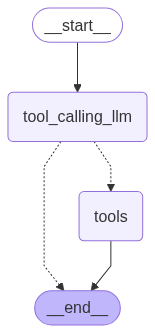

In [8]:
# 导入必要的模块
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# 定义工具调用节点
def tool_calling_llm(state: MessagesState):
    """
    工具调用节点函数
    这个节点负责调用带有工具的大语言模型

    Args:
        state: 包含消息列表的状态对象

    Returns:
        包含模型响应的新状态
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 构建LangGraph图
print("正在构建路由器图...")

# 创建状态图构建器，使用MessagesState作为状态类型
builder = StateGraph(MessagesState)

# 添加节点
# 1. 工具调用节点：负责调用大语言模型
builder.add_node("tool_calling_llm", tool_calling_llm)

# 2. 工具执行节点：负责执行具体的工具
builder.add_node("tools", ToolNode([multiply]))

# 添加边（连接）
# 从开始节点到工具调用节点
builder.add_edge(START, "tool_calling_llm")

# 添加条件边：从工具调用节点根据条件路由
builder.add_conditional_edges(
    "tool_calling_llm",
    # 条件判断逻辑：
    # - 如果助手的最新消息是工具调用 -> tools_condition 路由到 tools 节点
    # - 如果助手的最新消息不是工具调用 -> tools_condition 路由到 END 节点
    tools_condition,
)

# 从工具节点到结束节点
builder.add_edge("tools", END)

# 编译图
graph = builder.compile()

print("图构建完成！")

# 显示图的可视化结构
print("路由器图结构：")
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# 测试路由器功能
from langchain_core.messages import HumanMessage

print("=" * 50)
print("测试1：需要工具调用的数学问题")
print("=" * 50)

# 创建一个需要工具调用的问题
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]

# 调用图进行推理
print("正在处理用户问题...")
result = graph.invoke({"messages": messages})

# 显示所有消息（包括用户问题、模型响应、工具调用和工具结果）
print("\n对话流程：")
for i, m in enumerate(result['messages']):
    print(f"\n步骤 {i+1}:")
    m.pretty_print()

测试1：需要工具调用的数学问题
正在处理用户问题...

对话流程：

步骤 1:
================================ Human Message =================================

Hello, what is 2 multiplied by 2?

步骤 2:
================================== Ai Message ==================================
Tool Calls:
  multiply (call_EnGA7tYE0O4urlfAYK1CkYdJ)
 Call ID: call_EnGA7tYE0O4urlfAYK1CkYdJ
  Args:
    a: 2
    b: 2

步骤 3:
================================= Tool Message =================================
Name: multiply

4


## 测试结果分析

现在我们可以看到图成功运行了工具！

它返回了一个 `ToolMessage`，这表明：
1. **模型识别**：大语言模型识别出这是一个需要计算的数学问题
2. **工具调用**：模型决定调用 `multiply` 工具
3. **工具执行**：`ToolNode` 执行了乘法计算
4. **结果返回**：工具执行结果被包装成 `ToolMessage` 返回

## LangGraph Studio 可视化调试

**⚠️ 重要说明**

现在可以在本地运行并在浏览器中打开Studio。这是在本地运行Studio的首选方式。

### 启动本地开发服务器

在终端中进入本模块的 `/studio` 目录，运行以下命令：

```bash
langgraph dev
```

您应该看到以下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

### 使用Studio

1. 打开浏览器并导航到Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`
2. 在Studio中加载 `router`，它使用 `module-1/studio/router.py` 中设置的 `module-1/studio/langgraph.json`

Studio提供了强大的可视化调试功能，让您能够：
- 实时查看图的执行流程
- 调试每个节点的输入输出
- 测试不同的用户输入
- 监控工具调用的执行过程

In [10]:
# 检查运行环境
# 如果运行在Google Colab环境中，则无法使用LangGraph Studio
if 'google.colab' in str(get_ipython()):
    print("⚠️ 注意：LangGraph Studio目前不支持在Google Colab中运行")
    print("请在本地环境中运行此notebook以使用Studio功能")
    # 不抛出异常，让代码继续运行
else:
    print("✅ 环境检查通过，可以使用LangGraph Studio")

⚠️ 注意：LangGraph Studio目前不支持在Google Colab中运行
请在本地环境中运行此notebook以使用Studio功能


In [ ]:
# 测试2：不需要工具调用的普通对话
print("\n" + "=" * 50)
print("测试2：普通对话（不需要工具调用）")
print("=" * 50)

# 创建一个不需要工具调用的问题
messages2 = [HumanMessage(content="你好，今天天气怎么样？")]

# 调用图进行推理
print("正在处理用户问题...")
result2 = graph.invoke({"messages": messages2})

# 显示所有消息
print("\n对话流程：")
for i, m in enumerate(result2['messages']):
    print(f"\n步骤 {i+1}:")
    m.pretty_print()

print("\n" + "=" * 50)
print("测试总结")
print("=" * 50)
print("✅ 测试1：数学问题 -> 模型调用工具进行计算")
print("✅ 测试2：普通对话 -> 模型直接回复，无需工具")
print("🎉 路由器模式工作正常！")


## 学习总结

### 路由器模式的核心概念

通过这个示例，我们学习了路由器模式的关键概念：

1. **状态管理**：使用 `MessagesState` 来管理对话历史
2. **节点设计**：
   - `tool_calling_llm`：负责调用大语言模型
   - `tools`：负责执行具体工具
3. **条件路由**：使用 `tools_condition` 根据模型输出决定下一步
4. **工具绑定**：使用 `bind_tools()` 将工具绑定到模型

### 实际应用场景

路由器模式在实际应用中有广泛用途：

- **智能客服**：根据用户问题类型路由到不同的处理模块
- **代码助手**：根据编程问题决定是否调用代码执行工具
- **数据分析**：根据查询类型决定是否调用数据处理工具
- **多模态应用**：根据输入类型决定是否调用图像或音频处理工具

### 下一步学习

掌握了路由器模式后，您可以继续学习：
- 更复杂的多工具路由
- 状态管理和持久化
- 错误处理和重试机制
- 与外部系统的集成
